# Mar ??, 2022 ()

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_dir = pjoin(tmp_dir, 'fig_paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice(128)
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).load_group(use_centroid=False)
gr_bold = Group(**props_bold).fit_group(use_centroid=False)

remove = [
    n for n, lbl in gr_ca.n2l.items()
    if lbl not in gr_bold.n2l.values()
]
include = np.delete(np.arange(len(gr_ca.n2l)), remove)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi[:, include],
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

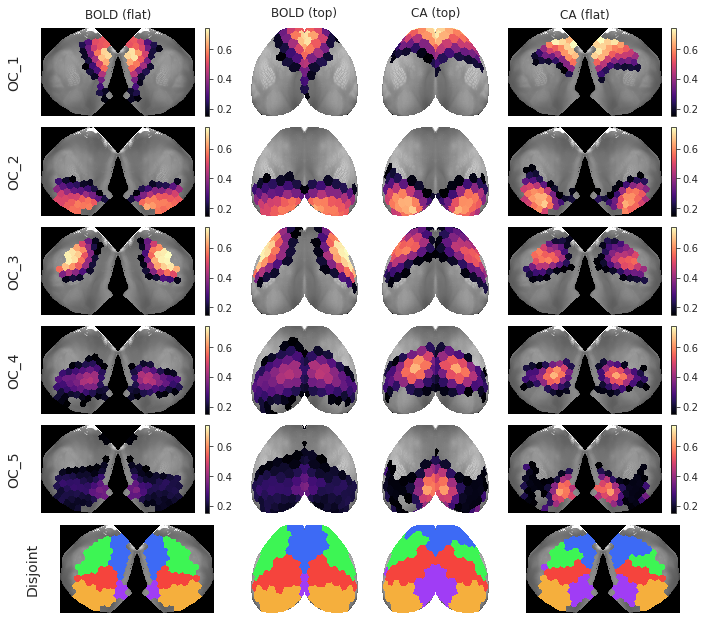

In [5]:
proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bold,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    min_thres=0.15,
)

In [6]:
x = np.load(pjoin(gr_bold.path, 'run_gam.npy'), mmap_mode='r')
pi = pi_from_gam(x)
pi = bn.nanmean(bn.nanmean(pi, 2), 1)
x.shape, pi.shape

((10, 3, 4, 1000, 5, 174), (10, 5, 174))

In [7]:
%%time

i, j, k = x.shape[:3]
dims = {'ses': j, 'run': k}
# dims = {'sub': i, 'ses': j, 'run': k}

n_resamples = 300

b_anim = bootstrap(
    x=x[6],
    n_resamples=n_resamples,
    batch=5,
    # skip=['sub'],
    dims=dims,
    est=None,
)
b_anim.shape

CPU times: user 11.2 s, sys: 2min 41s, total: 2min 52s
Wall time: 2min 53s


(300, 3, 4, 1000, 5, 174)

In [8]:
b_anim = pi_from_gam(b_anim)
b_anim = bn.nanmean(bn.nanmean(b_anim, 2), 1)
se_anim = np.nanstd(b_anim, axis=0, ddof=1)

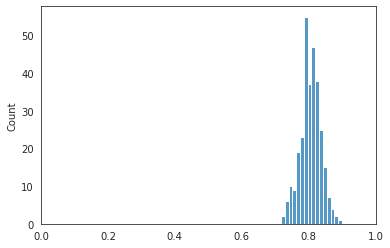

In [9]:
sns.histplot(b_anim[:, 2, 17])
plt.xlim(0, 1);

In [12]:
ci = 0.99
whis = (1 + ci) / 2
t = sp_stats.t.ppf(whis, 11)
t

3.105806513221101

In [15]:
for i in range(5):
    lo = pi[6, i, 17] - se_anim[i, 17] * t
    print(i, lo, lo < 0.01)

0 0.0018451115465250717 True

1 -0.012982247711716202 True

2 0.7125058300630346 False

3 -0.023461888994485126 True

4 -0.001914532239937988 True

In [16]:
vlines = [0.19, 0.86]
hlines = [16]

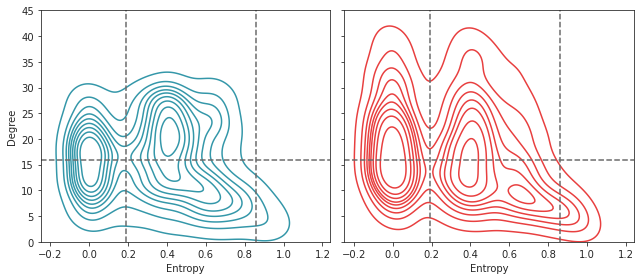

In [164]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

In [165]:
selected = ['Prefrontal', 'Somatomotor', 'Visual', 'Medial']

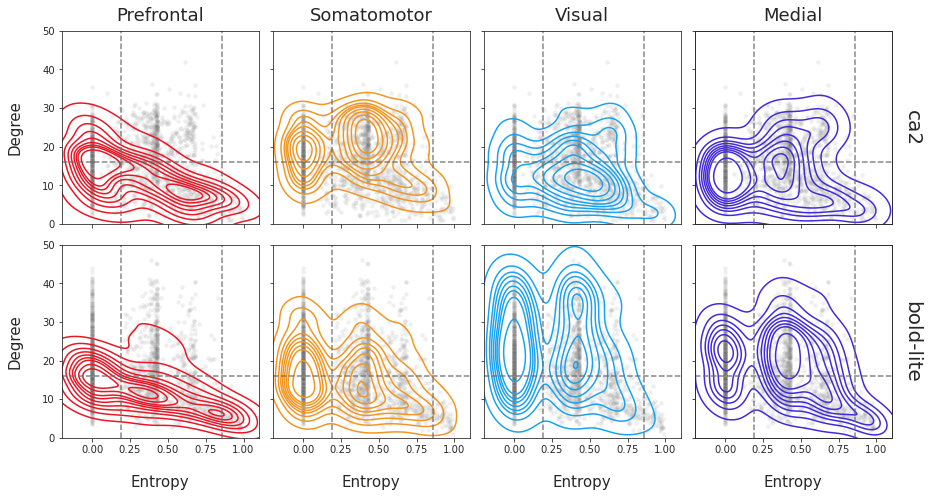

In [166]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--', alpha=0.8)
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--', alpha=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=20,
            alpha=0.1,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
ax.set_ylim((0, 50))
ax.set_xlim((-0.2, 1.1))

plt.show()

In [167]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

vedges, hedges

([0, 0.19, 0.86, 1], [0, 16, 100])

In [168]:
coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 16), (0, 0.19)),
    '01': ((0, 16), (0.19, 0.86)),
    '02': ((0, 16), (0.86, 1)),
    '10': ((16, 100), (0, 0.19)),
    '11': ((16, 100), (0.19, 0.86)),
    '12': ((16, 100), (0.86, 1))
}

In [169]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.anim_h, gr_ca.anim_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.anim_deg, gr_ca.anim_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = bn.nanmean(cond, 0)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

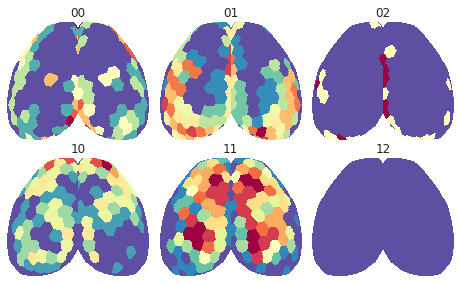

In [173]:
fig, axes = create_figure(2, 3, (6.5, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

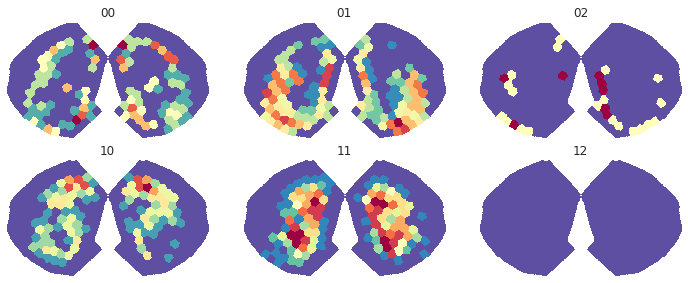

In [174]:
fig, axes = create_figure(2, 3, (10, 4))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['flat'] == 0, tr['proj-flat'][i])
    ax.imshow(x2p, cmap='Spectral_r')
    ax.set_title(k)
remove_ticks(axes)

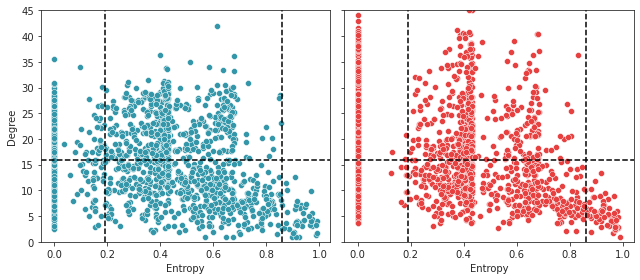

In [175]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='k', ls='--')
    for y in hlines:
        ax.axhline(y, color='k', ls='--')
    sns.scatterplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 45))

plt.show()

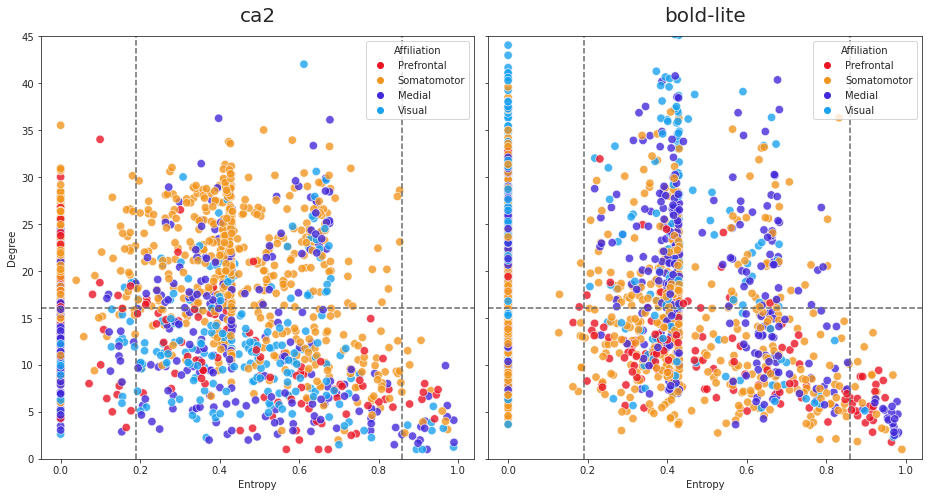

In [176]:
fig, axes = create_figure(1, 2, (13, 7), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()):
    for x in vlines:
        ax.axvline(x, color='dimgrey', ls='--')
    for y in hlines:
        ax.axhline(y, color='dimgrey', ls='--')
        
    _df = df.loc[
        (df['mode'] == mode) &
        (~df['Affiliation'].isin(['Auditory', 'Lateral']))
    ]
    sns.scatterplot(
        data=_df,
        x='Entropy',
        y='Degree',
        hue='Affiliation',
        palette=affil['colors'],
        s=70,
        alpha=0.8,
        ax=ax,
    )
    ax.set_title(mode, fontsize=20, y=1.02)
ax.set_ylim((0, 45))

plt.show()

### Group

In [53]:
num = len(gr_ca.grp_h.flat)
gr_ca.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_deg, 2), 1), 0)
gr_bold.grp_deg = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold.run_deg, 2), 1), 0)

In [56]:
df = pd.DataFrame({
    'mode': ['ca2'] * num + ['bold-lite'] * num,
    'Degree': list(gr_ca.grp_deg.flat) + list(gr_bold.grp_deg.flat),
    'Entropy': list(gr_ca.grp_h.flat) + list(gr_bold.grp_h.flat),
    'Affiliation': affil_included * 2,
})

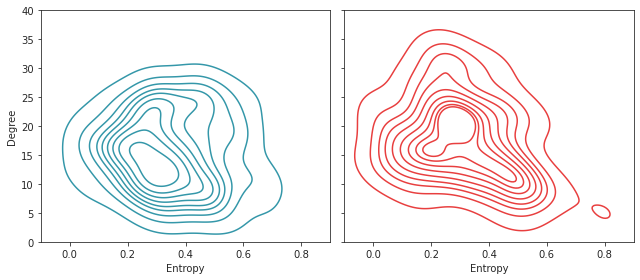

In [57]:
fig, axes = create_figure(1, 2, (9, 4), 'all', 'all')
for ax, (mode, c) in zip(axes.flat, pal.items()): 
    sns.kdeplot(
        data=df.loc[df['mode'] == mode],
        x='Entropy',
        y='Degree',
        # cmap='mako' if mode == 'ca2' else 'rocket',
        color=c,
        ax=ax,
    )
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))
plt.show()

In [76]:
vlines = [0.25, 0.43]
hlines = [18]

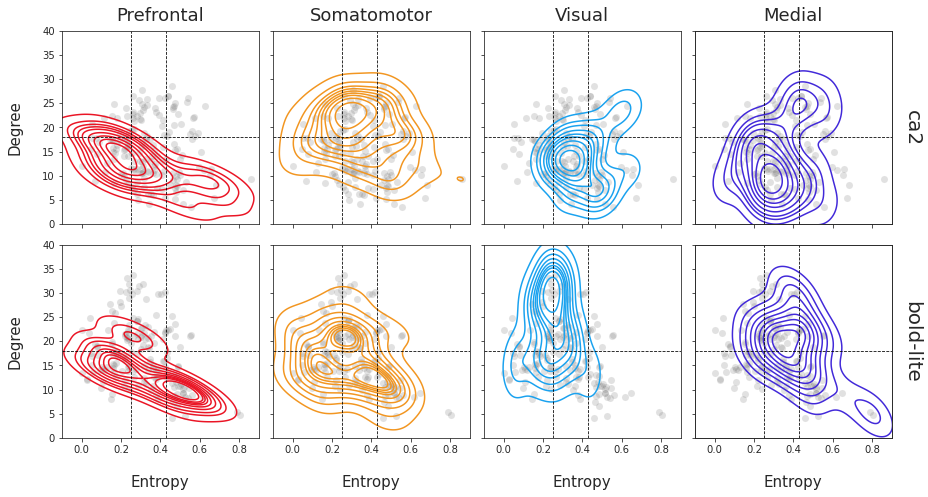

In [77]:
fig, axes = create_figure(2, len(selected), (13, 7), 'all', 'all')

for ax in axes.flat:
    for x in vlines:
        ax.axvline(x, color='k', ls='--', lw=0.8)
    for y in hlines:
        ax.axhline(y, color='k', ls='--', lw=0.8)

for i, af in enumerate(selected):
    for ax, (mode, c) in zip(axes[:, i].flat, pal.items()):
        _df = df.loc[
            (df['mode'] == mode) &
            (df['Affiliation'] == af)
        ]
        sns.scatterplot(
            data=df.loc[df['mode'] == mode],
            x='Entropy',
            y='Degree',
            color='dimgrey',
            s=50,
            alpha=0.2,
            ax=ax,
        )
        sns.kdeplot(
            data=_df,
            x='Entropy',
            y='Degree',
            color=affil['colors'][af],
            ax=ax,
        )
        if mode == 'ca2':
            ax.set_title(af, fontsize=18, y=1.02)
        else:
            ax.set_xlabel('Entropy', fontsize=15, labelpad=20)
        if i == len(selected) - 1:
            axtw = ax.twinx()
            axtw.set_ylabel(mode, fontsize=20, labelpad=30, rotation=-90)
            axtw.set_yticks([])
        elif i == 0:
            ax.set_ylabel('Degree', fontsize=15, labelpad=20)
            # axtw.yaxis.set_label_position("right")
ax.set_ylim((0, 40))
ax.set_xlim((-0.1, 0.9))

plt.show()

In [78]:
vedges = [0] + vlines + [1]
hedges = [0] + hlines + [100]

coordinates = {}
for i in range(len(hedges) - 1):
    for j in range(len(vedges) - 1):
        coordinates[f"{i}{j}"] = (
            (hedges[i], hedges[i + 1]),
            (vedges[j], vedges[j + 1]),
        )
coordinates

{
    '00': ((0, 18), (0, 0.25)),
    '01': ((0, 18), (0.25, 0.43)),
    '02': ((0, 18), (0.43, 1)),
    '10': ((18, 100), (0, 0.25)),
    '11': ((18, 100), (0.25, 0.43)),
    '12': ((18, 100), (0.43, 1))
}

In [81]:
carto_map = {}
for k, bounds in coordinates.items():
    (lower_deg, upper_deg), (lower_h, upper_h) = bounds
    cond_h = np.logical_and(lower_h <= gr_ca.grp_h, gr_ca.grp_h < upper_h)
    cond_deg = np.logical_and(lower_deg <= gr_ca.grp_deg, gr_ca.grp_deg < upper_deg)
    cond = np.logical_and(cond_h, cond_deg)
    carto_map[k] = cond.astype(float)
    
carto_vec = [np.expand_dims(e, axis=0) for e in carto_map.values()]
carto_vec = np.concatenate(carto_vec)
proj = gr_ca.project_vec(carto_vec, add_disjoint=False)
tr = gr_ca.trim2d(proj)

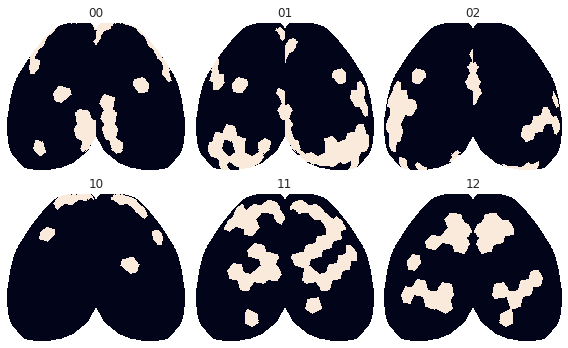

In [83]:
fig, axes = create_figure(2, 3, (8, 5))
for i, k in enumerate(coordinates):
    ax = axes.flat[i]
    x2p = mwh(tr['top'] == 0, tr['proj-top'][i])
    ax.imshow(x2p, cmap='rocket')
    ax.set_title(k)
remove_ticks(axes)